# Tarea II - Machine Learning II

Exercise done by Cedric Prieels.

## Kernel methods for regression

For this particular exercise, we were asked to create a script able to predict the temporal serie of the atmospheric CO2 using the latest data available from the National Oceanic and Atmospheric Administration https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html.

In particular, we were asked to write a function able to automatically download monthly data from a given FTP server (ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt) and able to convert this data into a numerical format to start analyzing it. Once done, we need to check if the data just downloaded matches the data previously obtained from the data common to both datasets.

Then, we need to search for the optimal parameters of the GP in order to predict the temporal CO2 serie using the latest data available, parameters that finally need to be compared to the ones obtained in the exercise done during the class using the data until December 2001. Finally, a complete prediction for the next 20 years needs to be done, including the confidence bands for our particular model.

### Download the data

First, let's download the data from the FTP server and keep this data in a txt file. If this file already exists, we don't download it again from the server as it is more efficient to directly read the previously downloaded file.

In [8]:
import urllib.request
import os.path

url = "ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt"
filename = "dataTarea2.txt" #Name given to our file

if not os.path.isfile(filename):
    urllib.request.urlcleanup() #Needed to clean the cache and execute this part of the code more than once
    urllib.request.urlretrieve(url, filename)
    print("The file has been downloaded and kept under the name: " + filename)
else:
    print("The file has already bee downloaded previously, so we skip this step.")

The file has already bee downloaded previously, so we skip this step.


### Read the data

Let's now check that the data has been correctly downloaded, read it and keep it in a panda data frame.

In [9]:
import numpy as np
import pandas as pd

engine='python'
try:
    with open(filename):
        #We skip the first rows that don't have any data and use a particular separator for this txt file
        data = pd.read_csv(filename, sep=r'\s{2,}', skiprows=72, header = None, na_values = -99.99, engine='python')
        data.columns = ['year', 'month', 'decimalDate', 'average', 'interpolated', 'trend', 'days'] #Set the column names
except IOError:
    print("An error occured with the data.")
    
#Finally, we print the first lines of the data frame
data.head()

,year,month,decimalDate,average,interpolated,trend,days
0,1958,3,1958.208,315.71,315.71,314.62,-1
1,1958,4,1958.292,317.45,317.45,315.29,-1
2,1958,5,1958.375,317.50,317.50,314.71,-1
3,1958,6,1958.458,NaN,317.10,314.85,-1
4,1958,7,1958.542,315.86,315.86,314.98,-1


Now we need to compute the decimalDate in the same way that has previously been done for the dataset containing the data until 2001, in order to be able to compare them directly later on.

In [10]:
modifiedData = data
modifiedData['decimalDate'] = np.around((modifiedData['year'] + (modifiedData['month'] -1 ) / 12), decimals=3)
modifiedData.head()

,year,month,decimalDate,average,interpolated,trend,days
0,1958,3,1958.167,315.71,315.71,314.62,-1
1,1958,4,1958.250,317.45,317.45,315.29,-1
2,1958,5,1958.333,317.50,317.50,314.71,-1
3,1958,6,1958.417,NaN,317.10,314.85,-1
4,1958,7,1958.500,315.86,315.86,314.98,-1


### Compare the data

Let's now compare the data just downloaded with the one obtained in the exercise done in class in order to check if the data matches for common dates. Let's first of all obtain this data.

In [11]:
#Define the data until 2001
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

#Inline plots
%matplotlib inline

def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187, cache=False)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

X, y = load_mauna_loa_atmospheric_co2()

Comparing the dates is quite easy since both datasets acutally use the same format, keeping the decimal year for which we can directly compare the CO2 values when the same value is present in both datasets.

In [12]:
#Create a data frame from this data as well for the comparison
data2001 = pd.DataFrame({'decimalDate': np.around(X, decimals=3).reshape(-1), 'average': np.around(y, decimals=2).reshape(-1)}, columns=['decimalDate', 'average'])
data2001.head()

,decimalDate,average
0,1958.167,316.10
1,1958.250,317.20
2,1958.333,317.43
3,1958.500,315.62
4,1958.583,314.95


In [13]:
#For the comparison, let's create a new dataframe joining the two data frames we already have based on the common value of decimalDate
merged = pd.merge(modifiedData, data2001, on='decimalDate')
merged.head()

#All is left is to compare the values of average_x and average_y in this data frame
averageX = merged['average_x']
averageY = merged['average_y']

#Since the measurements have not been done on the same day of the month, comparing the values obtained directly does not make much sense as most of them actually don't match exactly
comparison = averageX.eq(averageY) #Element wise comparison of the two series
comparison.value_counts() #Counts the number of False and True

False    511
True      10
dtype: int64

As we can see, the majority of the elements don't exactly match in the two datasets. This has an easy explanation: the decimalDate parameter was computed differently in both datasets: in the new one, the day of the month was taken into account to compute this parameters while this was not the case in the second dataset. Joining these two datasets therefore resulted in an empty data frame, since 0 matching decimalDates were found in both data frames.

To compensate for this, we artifically recomputed the decimalDate of the new dataset so that it does not take into account the day of the month of the measurement any more. This allowed to find more than 500 decimalDates common in both datasets, allowing us to compare them directly. 

However, this way of proceeding does come with a drawback: the artifical modification of the decimalDate in the new dataset means that a CO2 measurement is not currently assigned to a precise day of the month anymore, and this is a problem since we know this value actually slightly depends on the day of the month. This explains why such a low compatibility between the average_x and average_y of the two datasets has been found.

To compensate for this and still compare the two datasets, let's then use the numpy isclose method, with a relative tolerance set to 0.001.

In [108]:
sum(np.isclose(averageX, averageY, 0.001))

463

We can see that, using a relative tolerance quite low, 463 out of the 511 elements in the merged data frame actually match each other. This climbs to 519 when using a tolerange of 0.01, which is more than reasonnable to say that the data in both datasets is quite similar.

To finish this discussion, let's plot the data on the same plots to compare it and use the Kolmogorov-Smirnov test to compare both distributions. Given the high p-value obtained for this statistics, we can definitely not reject the hypothesis that the distributions of the two samples are the same.

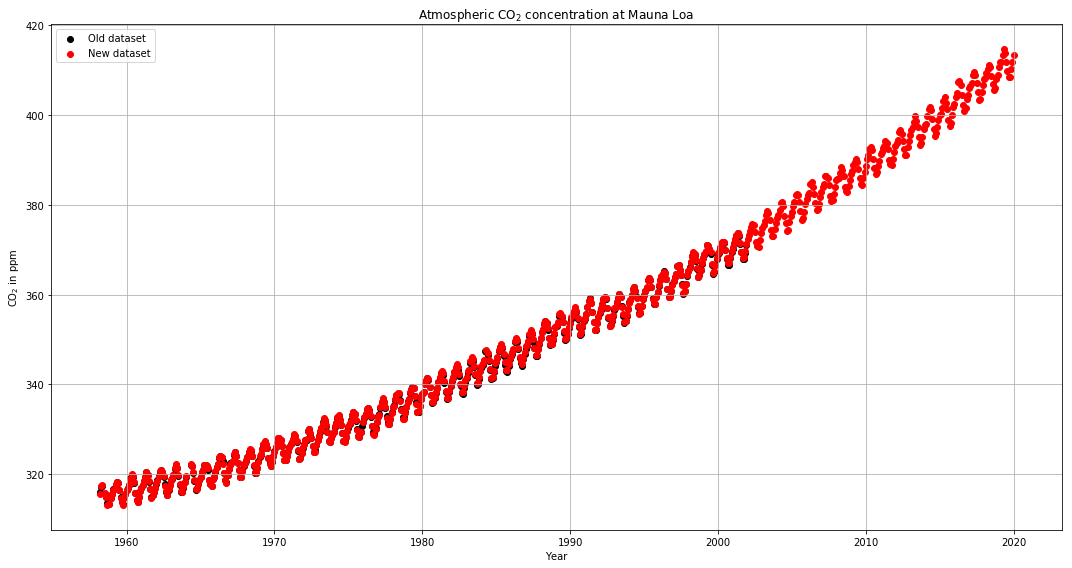

Ks_2sampResult(statistic=0.013435700575815779, pvalue=0.9999999999303759)

In [115]:
from scipy.stats import ks_2samp

#Plot both datasets
fig, ax = plt.subplots(figsize=(15,8))

plt.scatter(X, y, c='k', label="Old dataset")
plt.scatter(data['decimalDate'], data['average'], c='r', label="New dataset")
plt.grid(True)
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
ax.legend()
plt.show()

#Kolmogorov-Smirnov test
ks_2samp(merged['average_x'], merged['average_y'])

Now that we know the two datasets are quite similar, let's forget about the modifedData data frame and only use the data data frame for the rest of the exercise, which actually contains the precise and accurate value of decimalDate.

# Gaussian process regression

We will now apply a Gaussian Process regression using the kernel given in the reference used for this exercise: Section 5.4.3 of “Gaussian Processes for Machine Learning” [RW2006]. As seen during the exercise done in the class, the kernel used is composed of several terms that are responsible for explaining
different properties of the signal:

- a long term, smooth rising trend is to be explained by an RBF kernel. The
  RBF kernel with a large length-scale enforces this component to be smooth;
  it is not enforced that the trend is rising which leaves this choice to the
  GP. The specific length-scale and the amplitude are free hyperparameters.

- a seasonal component, which is to be explained by the periodic
  ExpSineSquared kernel with a fixed periodicity of 1 year. The length-scale
  of this periodic component, controlling its smoothness, is a free parameter.
  In order to allow decaying away from exact periodicity, the product with an
  RBF kernel is taken. The length-scale of this RBF component controls the
  decay time and is a further free parameter.

- smaller, medium term irregularities are to be explained by a
  RationalQuadratic kernel component, whose length-scale and alpha parameter,
  which determines the diffuseness of the length-scales, are to be determined.
  According to [RW2006], these irregularities can better be explained by
  a RationalQuadratic than an RBF kernel component, probably because it can
  accommodate several length-scales.

- a "noise" term, consisting of an RBF kernel contribution, which shall
  explain the correlated noise components such as local weather phenomena,
  and a WhiteKernel contribution for the white noise. The relative amplitudes
  and the RBF's length scale are further free parameters
  
Let's now define this kernel with generic parameters that will be optimized, as previously done.

In [14]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

# Kernel with generic parameters
k1 = C(50, (1e1, 1e+3)) * RBF(50,(1e0,1e5))  # long term smooth rising trend
k2 = C(5, (1e1, 1e+2)) * RBF(100,(1e0,1e5)) \
    * ExpSineSquared(length_scale=1.0, length_scale_bounds=(1e-1,1e1),
                     periodicity=1.0, periodicity_bounds="fixed")  # seasonal component
k3 = C(0.5, (1e-2, 1e1)) * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-2,1e3),
                                alpha=1.0, alpha_bounds=(1e-1,1e3)) # medium term irregularities
k4 = C(0.1, (1e-3, 1e+1)) * RBF(0.1,(1e-2,1e2)) \
    + WhiteKernel(noise_level=0.1**2,noise_level_bounds=(1e-4, 1e0)) # noise terms
kernel = k1 + k2 + k3 + k4

Let's now fit this GP to find the optimal parameters, as previously done as well.

In [15]:
from time import time
from sklearn.gaussian_process import GaussianProcessRegressor

# Fit the Gaussian Process regressor, and optimize the hyperparameters
gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True, n_restarts_optimizer=1)
t0 = time()

#Let's remove the NaN rows from our data frame
data = data.dropna()
X = np.array(data['decimalDate']).reshape(-1, 1) #Of course, we now use the new dataset
y = np.array(data['average'])

gp.fit(X, y)
print("Elapsed time: %0.3fs"%(time() - t0))

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

Elapsed time: 80.943s

Learned kernel: 31.6**2 * RBF(length_scale=28.1) + 3.16**2 * RBF(length_scale=170) * ExpSineSquared(length_scale=1.45, periodicity=1) + 0.73**2 * RationalQuadratic(alpha=0.286, length_scale=1.24) + 0.185**2 * RBF(length_scale=0.119) + WhiteKernel(noise_level=0.0416)
Log-marginal-likelihood: -191.086


In this case, we see that we obtain several parameters, the main one being the log-marginal likelihood, giving us an idea of the goodness of the model just obtained. In this case, we obtain -191.086, a worse than the -83.214 previosuly obtained by the other of the reference, considering the dataset until 2001. The predictions made will therefore be slightly worse in this case.

All the other parameters also give us an idea about the actual optimal parameters defining our model for the global warming (in parenthesis, the number previously obtained with the 2001 dataset):

- The majority of the signal, 31.6ppm (in diminution with respect to 34.4ppm) is obtained from the first part of the kernel, corresponding to a long term rising trend having a length scale of 28.1 years (48.1 years), quite lower compared to the value obtained previously
- Then, the period component accounts for 3.16 ppm (3.27 ppm value), has a decay time of 170 years (180 years), resulting in a periodical component quite close to the seasonal variation expected) and a length scale of 1.45 (1.44). This component did not change much with respect to the 2001 data, as expected for a seasonal variation.
- The noise level obtained from the White kernel is a bit higher (0.0416 with respect to 0.0336)

Finally, let's plot this optimal predictor along with the 2 sigma confidence level band for the next 20 years.

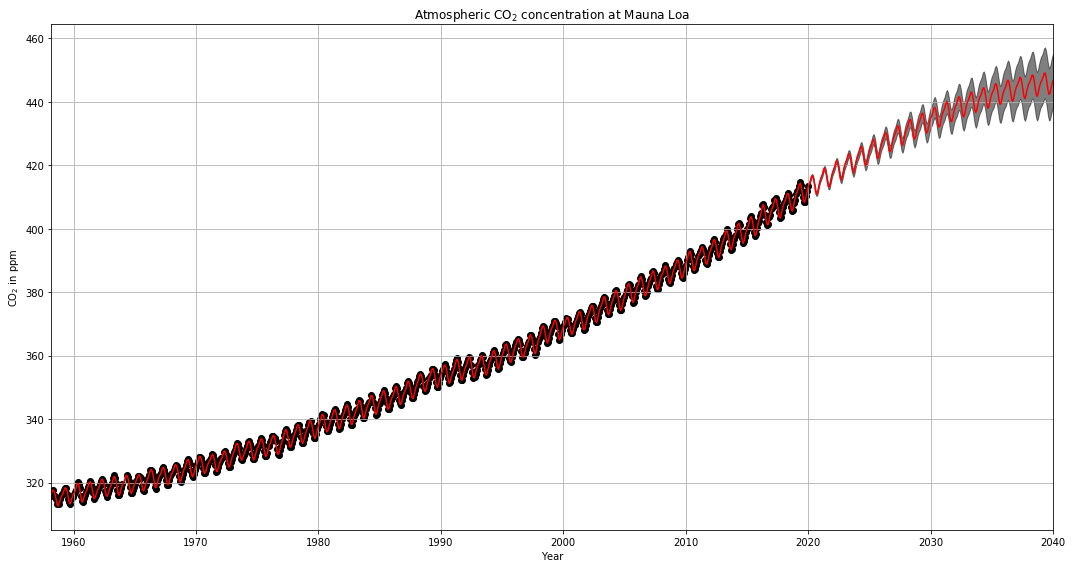

In [16]:
X_ = np.linspace(X.min(), X.max() + 20, 1000)[:, np.newaxis] #Predict for the next 20 years
y_pred, y_std = gp.predict(X_, return_std=True)

#Plot the prediction with the optimal parameters
fig = plt.figure(figsize=(15,8))
plt.scatter(X, y, c='k')
plt.plot(X_, y_pred, color='r')
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std, alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.grid(True)
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()

The apparent diminution of the curve is of course only due to our model which used gaussians functions that need at some point to go back to 0.